From Kaggle:

Rainfall is highly variable across space and time, making it notoriously tricky to measure. Rain gauges can be an effective measurement tool for a specific location, but it is impossible to have them everywhere. In order to have widespread coverage, data from weather radars is used to estimate rainfall nationwide. Unfortunately, these predictions never exactly match the measurements taken using rain gauges.

Recently, in an effort to improve their rainfall predictors, the U.S. National Weather Service upgraded their radar network to be polarimetric. These polarimetric radars are able to provide higher quality data than conventional Doppler radars because they transmit radio wave pulses with both horizontal and vertical orientations. 

Dual pulses make it easier to infer the size and type of precipitation because rain drops become flatter as they increase in size, whereas ice crystals tend to be elongated vertically.

In this competition, you are given snapshots of polarimetric radar values and asked to predict the hourly rain gauge total. A word of caution: many of the gauge values in the training dataset are implausible (gauges may get clogged, for example).

In [71]:
#Data is coming from here: https://www.kaggle.com/c/how-much-did-it-rain-ii/data

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#the dataset is too big for my computer memory, so I'm breaking it up into chunks
reader = pd.read_csv('/home/icarus/git/GA/GADS Final Project/train.csv', chunksize=100000)

In [72]:
df = reader.get_chunk()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 24 columns):
Id                       100000 non-null int64
minutes_past             100000 non-null int64
radardist_km             100000 non-null float64
Ref                      45076 non-null float64
Ref_5x5_10th             38462 non-null float64
Ref_5x5_50th             45211 non-null float64
Ref_5x5_90th             53336 non-null float64
RefComposite             48109 non-null float64
RefComposite_5x5_10th    42296 non-null float64
RefComposite_5x5_50th    48195 non-null float64
RefComposite_5x5_90th    55457 non-null float64
RhoHV                    36125 non-null float64
RhoHV_5x5_10th           30947 non-null float64
RhoHV_5x5_50th           36098 non-null float64
RhoHV_5x5_90th           42333 non-null float64
Zdr                      36125 non-null float64
Zdr_5x5_10th             30947 non-null float64
Zdr_5x5_50th             36098 non-null float64
Zdr_5x5_90th             42

In [97]:
df.corr()
#looking at some correlations.  
#Some, like the 10th/50th/90th percentile readings are clearly and intuitively correlated

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,RhoHV_5x5_10th,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,
Id,1.000000,-0.000219,0.005698,0.017880,0.015558,0.020702,0.019228,0.017535,0.018424,0.020868,0.015402,0.004228,0.008273,0.006730,0.000461,-0.004684,0.006814,-0.000764,-0.003606,0.000270,...
minutes_past,-0.000219,1.000000,0.001647,-0.029118,-0.026990,-0.029860,-0.047759,-0.035976,-0.031665,-0.037050,-0.048682,-0.003911,-0.005360,-0.011278,-0.008195,0.004896,0.008516,0.000805,-0.006342,0.001094,...
radardist_km,0.005698,0.001647,1.000000,0.061078,0.077582,0.058598,0.035905,0.001851,0.001682,-0.005570,-0.016133,0.106435,0.103911,0.121071,0.127977,-0.064021,-0.093646,-0.135510,-0.072712,0.001046,...
Ref,0.017880,-0.029118,0.061078,1.000000,0.772408,0.901111,0.753550,0.861697,0.751281,0.813900,0.677603,0.099799,0.190496,0.147739,-0.036846,-0.041435,0.101226,-0.034385,-0.149251,0.005173,...
Ref_5x5_10th,0.015558,-0.026990,0.077582,0.772408,1.000000,0.794381,0.605433,0.673719,0.828078,0.688320,0.539580,0.127712,0.256429,0.164573,-0.045250,-0.044627,0.133759,-0.059261,-0.164775,0.011039,...
Ref_5x5_50th,0.020702,-0.029860,0.058598,0.901111,0.794381,1.000000,0.769717,0.829145,0.801507,0.878660,0.690925,0.119588,0.214292,0.178206,-0.043720,-0.047086,0.116771,-0.035002,-0.166545,0.008307,...
Ref_5x5_90th,0.019228,-0.047759,0.035905,0.753550,0.605433,0.769717,1.000000,0.771534,0.657522,0.787649,0.910416,0.079654,0.144434,0.128387,-0.038934,-0.031015,0.089309,-0.001182,-0.133437,0.007053,...
RefComposite,0.017535,-0.035976,0.001851,0.861697,0.673719,0.829145,0.771534,1.000000,0.801166,0.919481,0.778612,0.092152,0.169603,0.149885,-0.049497,-0.036843,0.118704,-0.004040,-0.146173,0.003898,...
RefComposite_5x5_10th,0.018424,-0.031665,0.001682,0.751281,0.828078,0.801507,0.657522,0.801166,1.000000,0.820299,0.638479,0.118191,0.222952,0.180436,-0.059709,-0.043088,0.148817,-0.016576,-0.172200,0.005551,...
RefComposite_5x5_50th,0.020868,-0.037050,-0.005570,0.813900,0.688320,0.878660,0.787649,0.919481,0.820299,1.000000,0.786968,0.102956,0.178634,0.158152,-0.055262,-0.037995,0.125411,-0.003243,-0.156695,0.002660,...


In [74]:
#add visuailzation with pairplot here

In [75]:
#imputing mean valuse into NaNs, standardizing data to have 0 mean and unit variance
df = df.fillna(df.mean())
df = (df - df.mean()) / df.std()

/usr/lib/python2.7/dist-packages/numexpr/necompiler.py:742: DeprecationWarning: using `oa_ndim == 0` when `op_axes` is NULL is deprecated. Use `oa_ndim == -1` or the MultiNew iterator for NumPy <1.8 compatibility
  return compiled_ex(*arguments, **kwargs)
/usr/lib/python2.7/dist-packages/numexpr/necompiler.py:742: DeprecationWarning: using `oa_ndim == 0` when `op_axes` is NULL is deprecated. Use `oa_ndim == -1` or the MultiNew iterator for NumPy <1.8 compatibility
  return compiled_ex(*arguments, **kwargs)
/usr/lib/python2.7/dist-packages/numexpr/necompiler.py:742: DeprecationWarning: using `oa_ndim == 0` when `op_axes` is NULL is deprecated. Use `oa_ndim == -1` or the MultiNew iterator for NumPy <1.8 compatibility
  return compiled_ex(*arguments, **kwargs)


In [76]:
df.mean()


Id                       1.035743e-14
minutes_past            -9.303336e-17
radardist_km             5.179293e-15
Ref                     -4.205970e-12
Ref_5x5_10th            -2.415064e-12
Ref_5x5_50th            -3.405132e-12
Ref_5x5_90th             2.007730e-12
RefComposite            -4.464048e-12
RefComposite_5x5_10th   -5.084670e-12
RefComposite_5x5_50th    9.345977e-13
RefComposite_5x5_90th    8.312085e-13
RhoHV                    1.987310e-11
RhoHV_5x5_10th           1.726635e-11
RhoHV_5x5_50th           1.377658e-11
RhoHV_5x5_90th          -5.065210e-11
Zdr                     -1.104885e-12
Zdr_5x5_10th             3.346856e-13
Zdr_5x5_50th            -6.667979e-13
Zdr_5x5_90th            -8.616461e-13
Kdp                      1.210026e-15
Kdp_5x5_10th             1.185996e-12
Kdp_5x5_50th             3.842854e-13
Kdp_5x5_90th             2.304922e-12
Expected                 9.574885e-14
dtype: float64

In [77]:
df.std()

Id                       1
minutes_past             1
radardist_km             1
Ref                      1
Ref_5x5_10th             1
Ref_5x5_50th             1
Ref_5x5_90th             1
RefComposite             1
RefComposite_5x5_10th    1
RefComposite_5x5_50th    1
RefComposite_5x5_90th    1
RhoHV                    1
RhoHV_5x5_10th           1
RhoHV_5x5_50th           1
RhoHV_5x5_90th           1
Zdr                      1
Zdr_5x5_10th             1
Zdr_5x5_50th             1
Zdr_5x5_90th             1
Kdp                      1
Kdp_5x5_10th             1
Kdp_5x5_50th             1
Kdp_5x5_90th             1
Expected                 1
dtype: float64

In [78]:
#data is now full
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 24 columns):
Id                       100000 non-null float64
minutes_past             100000 non-null float64
radardist_km             100000 non-null float64
Ref                      100000 non-null float64
Ref_5x5_10th             100000 non-null float64
Ref_5x5_50th             100000 non-null float64
Ref_5x5_90th             100000 non-null float64
RefComposite             100000 non-null float64
RefComposite_5x5_10th    100000 non-null float64
RefComposite_5x5_50th    100000 non-null float64
RefComposite_5x5_90th    100000 non-null float64
RhoHV                    100000 non-null float64
RhoHV_5x5_10th           100000 non-null float64
RhoHV_5x5_50th           100000 non-null float64
RhoHV_5x5_90th           100000 non-null float64
Zdr                      100000 non-null float64
Zdr_5x5_10th             100000 non-null float64
Zdr_5x5_50th             100000 non-null float64
Zdr_5x5_

In [100]:
#selecting out feature columns and total rainfall data
#feature_columns = ['radardist_km', 'Ref', 'Ref_5x5_10th', 
 #                  'Ref_5x5_50th', 'Ref_5x5_90th', 'RefComposite', 
  #                 'RefComposite_5x5_10th', 'RefComposite_5x5_50th', 
   #                'RefComposite_5x5_90th', 'RhoHV', 'RhoHV_5x5_10th', 
    #               'RhoHV_5x5_50th', 'RhoHV_5x5_90th', 'Zdr', 
     #              'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th', 'Kdp',
      #             'Kdp_5x5_10th', 'Kdp_5x5_50th', 'Kdp_5x5_90th']

    
#reducing feature space a bit
feature_columns = ['radardist_km', 'Ref', 'RefComposite', 'RhoHV', 'Zdr', 
                    'Kdp',]
y = df['Expected']
X = df[feature_columns]


In [101]:
#the usual train test split

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

In [102]:
#trying out KNN Regression 
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=50)
model.fit(X_train, y_train)
y_predictions = model.predict(X_test)


In [103]:
#time to grade the model

from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, y_predictions)

print score

0.779584215496


In [104]:
#cross validation scoring
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, cv = 10, scoring = 'mean_squared_error')

print 'scores: ' + str(-1*scores)
print 'score average: ' + str(-1*scores.mean())

scores: [ 0.59762943  0.92118987  3.38515896  0.55093119  0.52825723  0.66768502
  0.84352408  0.55895925  0.5632378   0.82042662]
score average: 0.943699943426


In [86]:
errors = y_predictions-y_test
#lets look at the absolute errors present in a few histograms

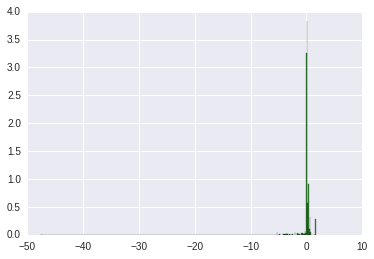

In [88]:
n, bins, patches = plt.hist(errors, 500, normed=1, facecolor='green', alpha=0.75)
plt.show()

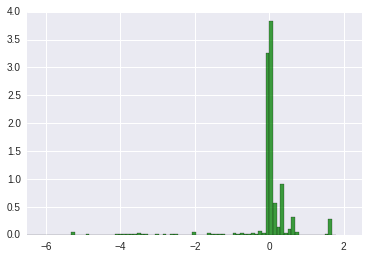

In [95]:
n, bins, patches = plt.hist(errors, 500, normed=1, facecolor='green', alpha=0.75)
plt.axis([-6.5,2.5,0,4])
plt.show()

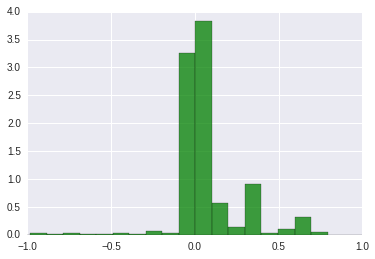

In [96]:
n, bins, patches = plt.hist(errors, 500, normed=1, facecolor='green', alpha=0.75)
plt.axis([-1,1,0,4])
plt.show()